In [4]:
import numpy as np
import matplotlib.pyplot as plt
import arepo
from tqdm import tqdm_notebook as tqdm

In [2]:
sim_list = ['Nbody']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [7]:
def get_cyl(sn, pt, center=np.array([200, 200, 200])):
    part = getattr(sn, 'part'+str(pt))
    pos = part.pos.value - center
    vel = part.vel.value
    acc = part.acce
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    phi = np.arctan2(pos[:,1], pos[:,0])
    z = pos[:,2]
    
    cosphi = pos[:,0]/R
    sinphi = pos[:,1]/R
    
    vR = cosphi * vel[:,0] + sinphi * vel[:,1]
    vphi = cosphi * vel[:,1] - sinphi * vel[:,0]
    vz = vel[:,2]
    
    aR = cosphi * acc[:,0] + sinphi * acc[:,1]
    aphi = cosphi * acc[:,1] - sinphi * acc[:,0]
    az = acc[:,2]
    
    return np.transpose([R, phi, z, vR, vphi, vz, aR, aphi, az])

In [41]:
from numba import njit
@njit
def _binned_average(x, y, bins):
    N = len(bins)
    
    sum_x_in_bin = np.zeros(N-1)
    sum_y_in_bin = np.zeros(N-1)
    N_in_bin = np.zeros(N-1)
    
    for i in range(len(x)):
        this_x = x[i]
        for j in range(N-1):
            if this_x > bins[j] and this_x < bins[j+1]:
                sum_x_in_bin[j] += x[i]
                sum_y_in_bin[j] += y[i]
                N_in_bin[j] += 1
    
    for j in range(N-1):
        if N_in_bin[j] > 0:
            sum_x_in_bin[j] /= N_in_bin[j]
            sum_y_in_bin[j] /= N_in_bin[j]
        else:
            sum_x_in_bin[j] = np.nan
            sum_y_in_bin[j] = np.nan
    
    return sum_x_in_bin, sum_y_in_bin
    
def binned_average(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)

    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins)

In [10]:
idx_list = np.arange(600, 610)
sn0_list = []

parttype = 2
fields = ['Masses', 'Coordinates', 'Velocities', 'Acceleration', 'ParticleIDs']

for idx in tqdm(idx_list):
    sn0 = read_snap(idx, 0, parttype=parttype, fields=fields)
    sn0_list.append(sn0)

A Jupyter Widget

In [9]:
# compute cylindrical coordinate representations
cyl0_list = []
for i,idx in enumerate(tqdm(idx_list)):
    cyl = get_cyl(sn0_list[i], 2, center=np.array([0., 0., 0.]))
    cyl0_list.append(cyl)

A Jupyter Widget

In [24]:
# first, i am going to see how well a simple Lz cut does
bar_Lz = 400

frac_in_i0_bar = []

for i,idx in enumerate(tqdm(idx_list)):
    # get list of stars which lie in the bar cut
    sn = sn0_list[i]
    cyl = cyl0_list[i]
    
    R = cyl[:,0]
    vphi = cyl[:,4]
    Lz = R * vphi
    
    bar_key = np.where(Lz < bar_Lz)[0]
    
    if i==0:
        bar_key_i0 = np.copy(bar_key)
        Ni0 = len(bar_key_i0)
        frac_in_i0_bar.append(1.)
    else:
        in_i0_bar = np.isin(bar_key, bar_key_i0)
        N_in_i0 = len(np.where(in_i0_bar)[0])
        frac_in_i0_bar.append(N_in_i0/Ni0)

A Jupyter Widget

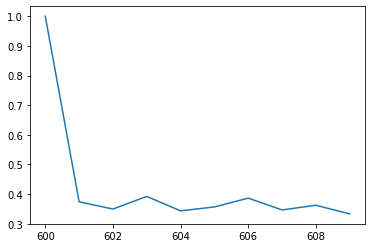

In [25]:
plt.plot(idx_list, frac_in_i0_bar)
plt.show()

In [26]:
import matplotlib as mpl

def quick_projection_key(x, y, m, key, width=20, nres=256, vmin=1E-3, vmax=1E0):
    extent = [-width/2.0, width/2.0, -width/2.0, width/2.0]
    range_xy = [[extent[0], extent[1]], [extent[0], extent[1]]]
    surf = (width/nres)**2.
    
    key_not = np.logical_not(key)
    
    heatmap_xy, _, _ = np.histogram2d(x[key], y[key], bins=(nres, nres), range=range_xy)
    heatmap_xy_not, _, _ = np.histogram2d(x[key_not], y[key_not], bins=(nres, nres), range=range_xy)
    heatmap_xy *= m/surf
    heatmap_xy_not *= m/surf
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    
    ax[0].imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), vmin=vmin, vmax=vmax)
    ax[1].imshow(heatmap_xy_not.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), vmin=vmin, vmax=vmax)
    
    return fig, ax

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


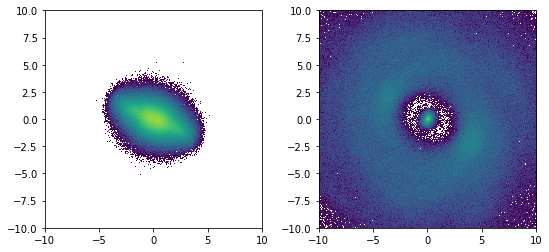

In [57]:
sn = sn0_list[0]
cyl = cyl0_list[0]
x, y = sn.part2.pos[:,0].value, sn.part2.pos[:,1].value

R = cyl[:,0]
vphi = cyl[:,4]
vR = cyl[:,3]

aR = cyl[:,6]

j = vphi / np.sqrt(- R * aR)

# key = R * vphi < np.minimum(200 + 100*R, 400)
key = j < 2 - 2 *(R/6)
fig, ax = quick_projection_key(x, y, sn.MassTable[2], key, nres=512)
plt.show()

A Jupyter Widget

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


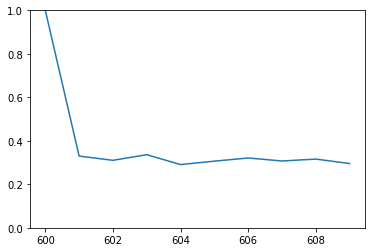

In [60]:
# first, i am going to see how well a simple Lz cut does
bar_j = 0.6

frac_in_i0_bar = []

for i,idx in enumerate(tqdm(idx_list)):
    # get list of stars which lie in the bar cut
    sn = sn0_list[i]
    cyl = cyl0_list[i]
    
    R = cyl[:,0]
    vphi = cyl[:,4]
    aR = cyl[:,6]
    
    j = vphi / np.sqrt(-R * aR)
    
    bar_key = np.where(j < 1.3*(1-R/6))[0]
    
    if i==0:
        bar_key_i0 = np.copy(bar_key)
        Ni0 = len(bar_key_i0)
        frac_in_i0_bar.append(1.)
    else:
        in_i0_bar = np.isin(bar_key, bar_key_i0)
        N_in_i0 = len(np.where(in_i0_bar)[0])
        frac_in_i0_bar.append(N_in_i0/Ni0)

plt.plot(idx_list, frac_in_i0_bar)
plt.ylim(0, 1)
plt.show()

3.04541015625


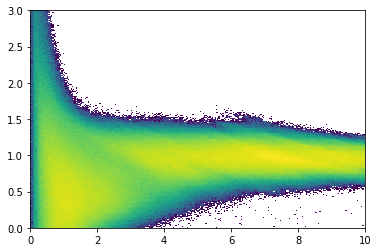

34.3940660215334


In [55]:
R = cyl[:,0]
vphi = cyl[:,4]
vR = cyl[:,3]
# plt.hist(vphi/R, bins=100)
rng = [[0, 10], [0, 3]]
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
# key = R * vphi < 300
heatmap, _, _ = np.histogram2d(R, j, bins=(256, 256), range=rng)

print(sn.Time)
plt.imshow(heatmap.T, origin='lower', extent=extent, norm=mpl.colors.LogNorm(), aspect='auto')
# plt.scatter(R, vphi/R)
plt.show()
print(np.median(vphi/R))